# Imports

In [52]:
from earth.utils import generateFilePathStr

import MySQLdb as sql
import h5py

import numpy as np
import pandas as pd
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from MulticoreTSNE import MulticoreTSNE as TSNE
import tensorflow as tf

import plotly.offline as plotly
import plotly.graph_objs as go
plotly.init_notebook_mode(connected=True)

# Generate Datasets

In [40]:
n_items = 10000
grid_size = 16

In [35]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']

In [36]:
db = sql.connect(db='earthdat', host='localhost', user='root', password='#Python95Comment')
cur = db.cursor()
cur.execute('SELECT lid, x_coord, y_coord, label FROM cloud_detection_clustering ORDER BY RAND() LIMIT {};'.format(n_items))
results = cur.fetchall()
db.close()

In [42]:
dataset = np.empty((n_items, grid_size ** 2 * len(bands)))
labels = np.empty((n_items,))

meta = []
with h5py.File(generateFilePathStr(kind='database'), 'r') as h:
    i = 0
    for lid, x, y, status in results:
        subimage = np.empty((len(bands), grid_size**2))
        for j, b in enumerate(bands):
            subimage[j] = h[lid][b][
                x - int(grid_size / 2) : x + int(grid_size / 2),
                y - int(grid_size / 2) : y + int(grid_size / 2)
            ].flatten()
        dataset[i] = subimage.flatten()
        labels[i] = status
        i += 1
        
        if status == 0:
            meta.append((lid, x, y))

In [43]:
dataset = dataset[labels != 2]
labels = labels[labels != 2]

In [44]:
dataset = dataset / (2 ** 16 - 1) * 255

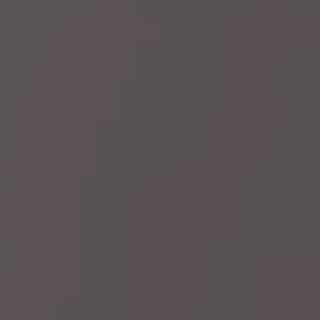

In [47]:
i = 160
sample_image = dataset[labels == 0][i].reshape((len(bands), grid_size, grid_size))[1:4].transpose(1, 2, 0)
Image.fromarray(np.kron(sample_image, np.ones((20, 20, 1))).astype('uint8'))

# 2D Scatter Plots

In [70]:
%%time
tsne = TSNE(2, perplexity=60, n_jobs=8, n_iter=5000)
ld_dataset = tsne.fit_transform(dataset)

CPU times: user 9min 26s, sys: 13 s, total: 9min 39s
Wall time: 3min 13s


In [71]:
fig0 = go.Scatter(
    x=ld_dataset[labels == 0][:,0],
    y=ld_dataset[labels == 0][:,1],
    marker={'size': 2},
    mode="markers"
)

fig1 = go.Scatter(
    x=ld_dataset[labels == 1][:,0],
    y=ld_dataset[labels == 1][:,1],
    marker={'size': 2},
    mode="markers"
)

plotly.iplot([fig0, fig1])

# Fitting 

In [163]:
dataset.shape

(34652, 8192)

In [269]:
m = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1)
m = m.fit(dataset, labels)

In [270]:
np.sum((m.predict(dataset) == labels)) / float(dataset.shape[0])

0.9780965023663858